In [2]:
import numpy as np 
import uproot 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import sys

def load_cms_data(filename="../raw_data/open_cms_data.root"):
    """This function loads events data from open CMS root files"""

    # The object returned by uproot.open represents a TDirectory inside the file (/).
    # We are interested in the Events branch
    events_tree = uproot.open(filename)['Events']

    # events_tree.show(name_width=100, typename_width=100)

    # The Collection we want is: recoPFJets_ak5PFJets__RECO

    recoPFJets = events_tree['recoPFJets_ak5PFJets__RECO.']['recoPFJets_ak5PFJets__RECO.obj']
    #recoPFJets.show(name_width=100, typename_width=100)

    prefix = 'recoPFJets_ak5PFJets__RECO.obj.'
    # Store the 27 variables we are interested in to a pandas dataframe
    dataframe = recoPFJets.arrays(
        [prefix + 'pt_', prefix + 'eta_', prefix + 'phi_', prefix + 'mass_', prefix + 'vertex_.fCoordinates.fX',
         prefix + 'vertex_.fCoordinates.fY', prefix + 'vertex_.fCoordinates.fZ', prefix + 'mJetArea', prefix + 'mPileupEnergy',
         prefix + 'm_specific.mChargedHadronEnergy', prefix + 'm_specific.mNeutralHadronEnergy',
         prefix + 'm_specific.mPhotonEnergy', prefix + 'm_specific.mElectronEnergy',
         prefix + 'm_specific.mMuonEnergy', prefix + 'm_specific.mHFHadronEnergy', prefix + 'm_specific.mHFEMEnergy',
         prefix + 'm_specific.mChargedHadronMultiplicity', prefix + 'm_specific.mNeutralHadronMultiplicity',
         prefix + 'm_specific.mPhotonMultiplicity', prefix + 'm_specific.mElectronMultiplicity', prefix + 'm_specific.mMuonMultiplicity',
         prefix + 'm_specific.mHFHadronMultiplicity', prefix + 'm_specific.mHFEMMultiplicity',
         prefix + 'm_specific.mChargedEmEnergy', prefix + 'm_specific.mChargedMuEnergy', prefix + 'm_specific.mNeutralEmEnergy',
         prefix + 'm_specific.mChargedMultiplicity', prefix + 'm_specific.mNeutralMultiplicity'],       library="pd")

    
    # Rename the column names to be shorter
    dataframe.columns = [ 'pt',   'eta',   'phi',   'mass',
                           'fX',   'fY',   'fZ',   'mJetArea',   'mPileupEnergy',
                           'mChargedHadronEnergy',   'mNeutralHadronEnergy',   'mPhotonEnergy',
                           'mElectronEnergy',   'mMuonEnergy',   'mHFHadronEnergy',
                           'mHFEMEnergy',   'mChargedHadronMultiplicity',   'mNeutralHadronMultiplicity',
                           'mPhotonMultiplicity',   'mElectronMultiplicity',   'mMuonMultiplicity',
                           'mHFHadronMultiplicity',   'mHFEMMultiplicity',   'mChargedEmEnergy',
                           'mChargedMuEnergy',   'mNeutralEmEnergy',   'mChargedMultiplicity',
                           'mNeutralMultiplicity']


    print("\nDataframe:")
    print(dataframe.head()) #Only first 5 rows of df
    dataframe.to_csv('27D_opensCMS_data.csv')
    return dataframe




In [3]:


fourvector = load_cms_data()
#Cutting off data so that only 4-vector data is left
fourvector = fourvector.iloc[:,0:4]
print("Altered df")
fourvector.info()
#Normalize Data
fourvector[fourvector.columns] = StandardScaler().fit_transform(fourvector)
print(fourvector.head())
#Dropping the value with pT > 20
fourvector.drop(fourvector[fourvector['pt']>400].index, inplace=True)




Dataframe:
                       pt       eta       phi       mass   fX   fY   fZ  \
entry subentry                                                            
0     0         97.293968 -1.046758 -1.378504  16.212225  0.0  0.0  0.0   
      1         86.607674 -1.797043  2.055401  16.508511  0.0  0.0  0.0   
      2         40.815239 -1.400267  1.314550  11.218516  0.0  0.0  0.0   
      3         25.064486 -2.256013 -2.359081   7.330747  0.0  0.0  0.0   
      4         24.530922 -2.289618  0.647938   7.968142  0.0  0.0  0.0   

                mJetArea  mPileupEnergy  mChargedHadronEnergy  ...  \
entry subentry                                                 ...   
0     0         0.797865            0.0             52.935665  ...   
      1         0.797865            0.0             42.604038  ...   
      2         0.728052            0.0             51.369270  ...   
      3         0.767945            0.0             74.517921  ...   
      4         0.847731            0.0   

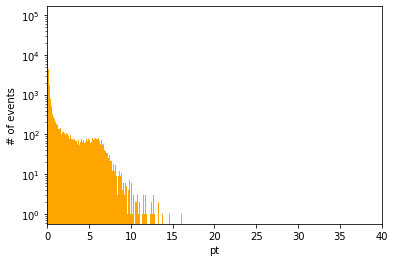

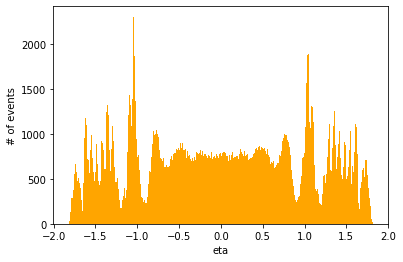

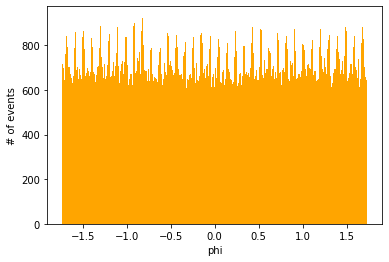

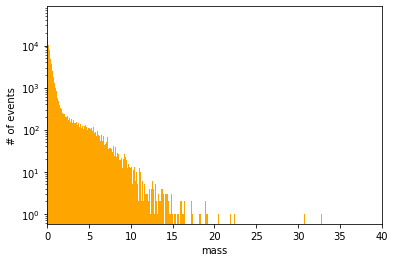

In [4]:
n_bins = 100
variable_list = ["pt", "eta", "phi", "mass"]

n_bins = 1000
#mass and pt are in logscale
for kk in range(0,4):
    if kk ==0 or kk==3:
        plt.yscale("log")
        plt.xlim(right=40)
        
    n_hist_data, bin_edges, _ = plt.hist(fourvector[variable_list[kk]], color='orange', label='Input', alpha=1, bins=n_bins)
    plt.xlabel(xlabel=variable_list[kk])
    plt.ylabel('# of events')
    plt.savefig("./Original Data(4Vector)")
    plt.show()

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

fourvector = shuffle(fourvector)
train_x, test_x = train_test_split(fourvector, test_size=0.2, random_state=1)
train_y = train_x
test_y = test_x
print('Train data shape: ')
print(train_x.shape)
print('Test data shape: ')
print(test_x.shape)
print(test_x.columns)
data = torch.tensor(test_x.values, dtype=torch.float)

train_ds = TensorDataset(torch.tensor(train_x.values, dtype=torch.float), torch.tensor(train_y.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(test_x.values, dtype=torch.float), torch.tensor(test_y.values, dtype=torch.float))

Train data shape: 
(573156, 4)
Test data shape: 
(143289, 4)
Index(['pt', 'eta', 'phi', 'mass'], dtype='object')


In [6]:
bs = 512 #Initially set at 256, Trying 500, 1000, 100
##512 is the first to not give spikes
# Converts the TensorDataset into a DataLoader object and combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs)
dls = core.DataLoaders(train_dl, valid_dl)

In [7]:
def train_AE(dls,latent_space, neurons_list, act_list, weight_decay):    
    for x,y,z in [(x,y,z) for x in latent_space for y in neurons_list for z in act_list]:
        #Have a function for this
        model = AE(4,x,y,z)
        #This would already be defined
        recorder = learner.Recorder()
        learn = learner.Learner(dls, model=model, wd=weight_decay, loss_func=nn.MSELoss())
        start = time.perf_counter() # Starts timer
        # train our autoencoder for 100 epochs
        learn.fit_one_cycle(1, 0.00108)
        end = time.perf_counter() # Ends timer
        delta_t = end - start
        print(delta_t)
        z = str(z)
        n1,n2,n3 = tuple(y)
        save_dir = '../plots/' +str(n1) +'-'+str(n2)+'-'+str(n3) +'-'+str(x) +'__' +z[0:9]
        try:
            os.mkdir(save_dir)
        except FileExistsError:
            shutil.rmtree(save_dir)
        finally:
            os.mkdir(save_dir)


        #Plotting Loss and recording validation and time
        recorder.plot_loss()
        plt.savefig(os.path.join(save_dir,'_loss'), format='png')
        plt.clf()
        val = learn.validate()
        val =str(val)
        valid_time_file = save_dir + '/valid_time'
        f = open(valid_time_file,'w')
        f.write("Validation Error: ")
        f.write(val)
        f.write('\n')
        f.write(str(delta_t))
        f.close()

3 [200, 100, 10] Tanh()


epoch,train_loss,valid_loss,time
0,0.015174,0.014782,00:14
0,0.015174,0.014782,00:14


14.362286699000833


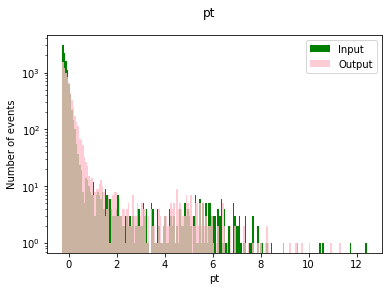

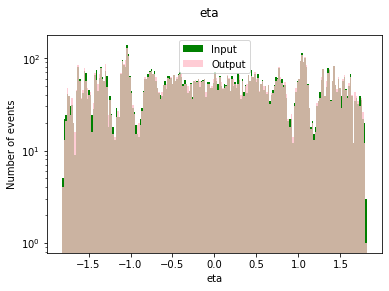

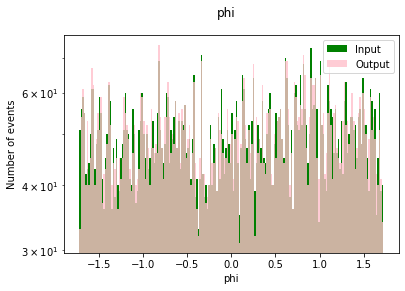

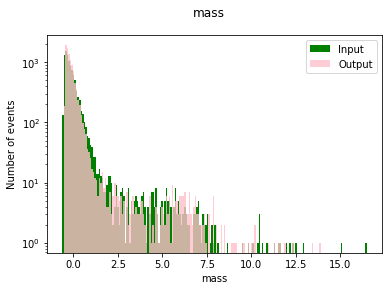

In [8]:
from Plotting_AE import *
from model_functions import *
from fastai.metrics import mse, partial
from fastai.callback.tracker import EarlyStoppingCallback
from fastai.test_utils import *
import time
from fastai.callback import schedule
import os
import shutil
import Wulff_Functions as wu

#Multiply to get total number of combinations

loss_function = nn.MSELoss()
weight_decay = 1e-6
latent_space = [3]
neurons_list = [[200,100,10]]
act_list = [nn.Tanh()]

#This takes all the arguments given above and loops over all possible arrangements
#For some reason this part of the code does not work within a function
for x,y,z in [(x,y,z) for x in latent_space for y in neurons_list for z in act_list]:
    print(x,y,z)
    model = AE(4,x,y,z)
    #This would already be defined
    recorder = learner.Recorder()
    learn = learner.Learner(dls, model=model, wd=weight_decay, loss_func=loss_function, cbs=recorder)
    start = time.perf_counter() # Starts timer
    # train our autoencoder for 100 epochs
    learn.fit_one_cycle(1, 0.00108)
    end = time.perf_counter() # Ends timer
    delta_t = end - start
    print(delta_t)
    z = str(z)
    n1,n2,n3 = tuple(y)
    save_dir = f'../plots/{n1}-{n2}-{n3}-{x}__{z[0:9]}'
    
    #Creates a folder containing the plot_loss, validation, time if it doesn't already exist.
    #If the folder already exists, the program deletes the folder and recreates it.d
    try:
        os.mkdir(save_dir)
    except FileExistsError:
        shutil.rmtree(save_dir)
    finally:
        os.mkdir(save_dir)
    
    
    #Plotting Loss and recording validation and time
    recorder.plot_loss()
    plt.savefig(os.path.join(save_dir,'_loss'), format='png')
    plt.clf()
    val = learn.validate()
    val =str(val)
    valid_time_file = save_dir + '/valid_time'
    f = open(valid_time_file,'w')
    f.write("Validation Error: ")
    f.write(val)
    f.write('\n')
    f.write(str(delta_t))
    f.close()
    
    #Plotting Final Results
    plt.clf
    plt.close('all')
    unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
    variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
    line_style = ['--', '-']
    colors = ['pink', 'green']
    markers = ['*', 's']

    model.to('cpu')
    save = True
    idxs = (0, 10000)  # Choose events to compare
    data = torch.tensor(test_x[idxs[0]:idxs[1]].values, dtype=torch.float)

    pred = model(data)
    pred = pred.detach().numpy()
    data = data.detach().numpy()

    data_df = pd.DataFrame(data, columns=test_x.columns)
    pred_df = pd.DataFrame(pred, columns=test_x.columns)

    alph = 0.8
    n_bins = 200
    
    #Plotting output data
    for kk in np.arange(4):
        plt.figure()
        n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
        n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
        plt.suptitle(test_x.columns[kk])
        plt.xlabel(test_x.columns[kk])
        plt.ylabel('Number of events')
        # ms.sciy()
        plt.yscale('log')
        if save:
            plt.savefig(os.path.join(save_dir,test_x.columns[kk] + '.png'))
        plt.legend()
    
    

In [9]:
import seaborn as sns
import matplotlib as mpl
from corner import corner



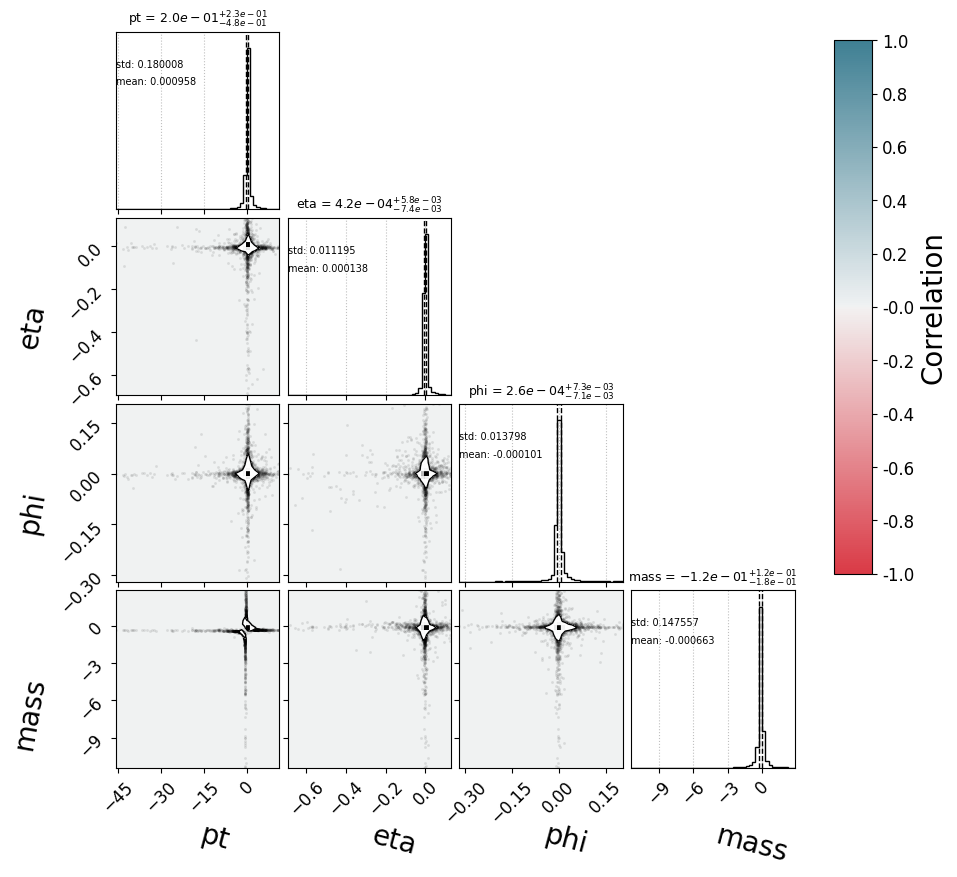

In [10]:
rel_diff_list = ['pt', 'eta', 'phi', 'mass']
corner_groups = [rel_diff_list]
wu.corr_matrix(4,3,'.',pred_df,data_df,rel_diff_list,corner_groups)

       
    
